## Setup

In [1]:
# %pip install matplotlib
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Part 0: Building intuition

In [3]:
# Let us try to get an understanding of derivatives first and what results they provide
def f(x):
    return 2*x**2 + 5

In [4]:
f(3.0)

23.0

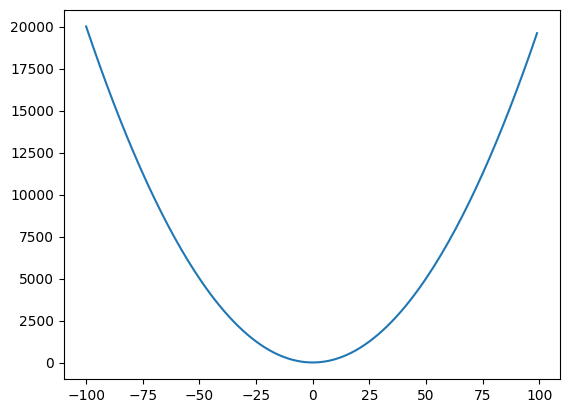

In [5]:
xs = np.arange(-100,100,1)
ys = f(xs)
plt.plot(xs,ys)

We are going to simulate a derivative as the equation

df/dx = (f(x+h) - f(x))/h

with a very small value of h instead to show x -> 0

In [6]:
h = 0.00000000001
x = 3.0
dfdx = (f(x+h) - f(x))/h
dfdx

12.000000992884452

Now, we will move onto more complex functions

In [7]:
h = 0.00000001

#inputs
a = 2.0
b = -5.0
c = -1.0

# Here we are differentiating with regards to a
d1 = a * b + c
a = a + h
d2 = a * b + c
slope = (d2-d1)/h
print(f'Slope: {slope}')

Slope: -5.000000058430487


## Part 2 : Setting up custom datatypes 

### Value

A datatype for storing the values of scalar quantities

Functionalities
-> Keeps track of the two value objects that created the current object (_prev stores the operands and _op stores the operator)
-> Supports basic arithematic operations

In [8]:
class Value:
    def __init__(self,data:int, _children=(), _op = '', label = '') -> None:
        self.data = data
        self._prev = set(_children)
        # grad is the dependance
        self.grad = 0.0
        # function to find the grad of the current variable by back prop
        self._backward = lambda: None
        self._op = _op
        self.label = label # just the name of the scalar
    
    # whenever an object itself is printed, this function is called
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        # This handles the case where we have one primitive datatype and the other is a Value object
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other),'+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward 
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self,other):
        return self + (-other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __pow__(self,other):
        '''Power function
            Only supports int and float datatypes as powers for now
        '''
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,),f'f**{other}')

        def _backward():
            self.grad += (other) * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other

    def __rmul__(self,other):
        '''This function will be called if other * self is called and python can't find a way to do that'''
        return self * other

    

    def __truediv__(self,other):
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
        out = Value(t, (self,),'tanh')
        
        def _backward():
            self.grad += 1 - t**2 * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [9]:
val1 = Value(10)
val2 = Value(2)
val3 = val1 * val2
val4 = val3 * val1 
val5 = val4 + val3
val1.label = 'val1'
val2.label = 'val2'
val3.label = 'val3'
val4.label = 'val4'

In [10]:
from graphviz import Digraph

def trace(root):
    '''Utility function to trace the equation leading to a value
    Step 1: Add node if not already in nodes
    Step 2: Check all _prev of the node if it is a new node and add to edges
    Step 3: Continue recursively through the children
    '''
    nodes, edges = set(), set()

    def build(v):
        '''Actually goes through all children'''
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg')
    # LR is left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n)) # inbuilt function of python which gives us the uid of an object

        # Now, we will create a rectangular node for the values
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.2f }" % (n.label,n.data, n.grad),shape = 'record')
        if n._op:
            # an operator node will be circular
            dot.node(name=uid+n._op, label = n._op)
            #connect this node to it
            dot.edge(uid+n._op,uid)

    # we previously only added the nodes and the op that created them
    for n1,n2 in edges:
        # Connecting the parent nodes to the op of the children
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)     
    return dot

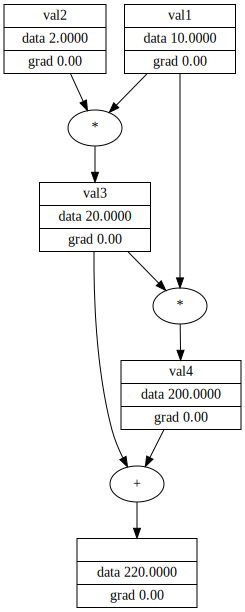

In [11]:
draw_dot(val5)

### Finding gradient of the values one-by-one

In [12]:
val4.grad = 1.0

In [13]:
def lol(lol_index = 0):
    '''Created a function so that, the value of the original variables don't change'''
    h = 0.00001


    val1 = Value(data = 10, label='val1')
    val2 = Value(data = 2, label = 'val2')
    val3 = val1 + val2
    val3.label = 'val3'
    val4 = val3 * val1
    val4.label = 'val4'
    L1 = val4.data

    if lol_index == 0:
        val1 = Value(data = 10 + h, label='val1')
    elif lol_index == 1:
        val2 = Value(data = 2 + h, label = 'val2')
    elif lol_index == 2:
        val3 = val1 + val2
        val3.data +=h
        val3.label = 'val3'
    else:
        val4 = val3 * val1
        val4.data += h
        val4.label = 'val4'
    L2 = val4.data

    return ((L2-L1)/h)


    


In [14]:
val1.grad = lol(0)
val1.grad = lol(1)
val1.grad = lol(2)
val1.grad = lol(3)
val2.grad

0.0

## Part 3 Implementing for a neuron

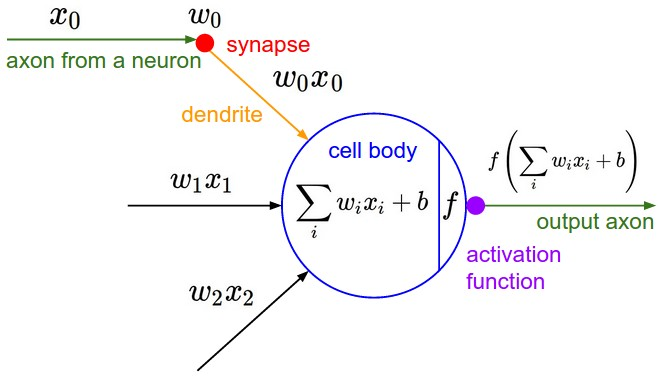  
Activation or squashing function is used to bring values within a range  


For example we use tanh as an activation function which caps values between -1 and 1

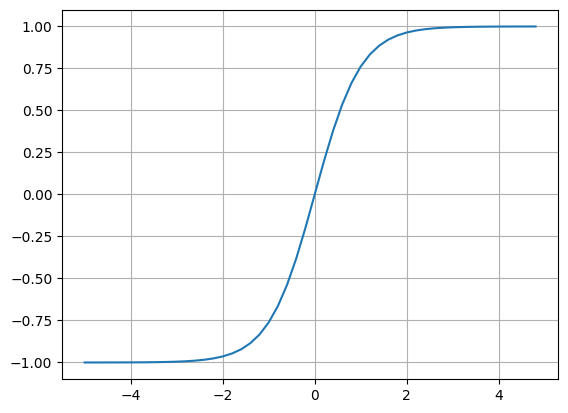

In [15]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));plt.grid()

Let us now create a basic 2 dimensional neuron which will take 2 inputs and give one output

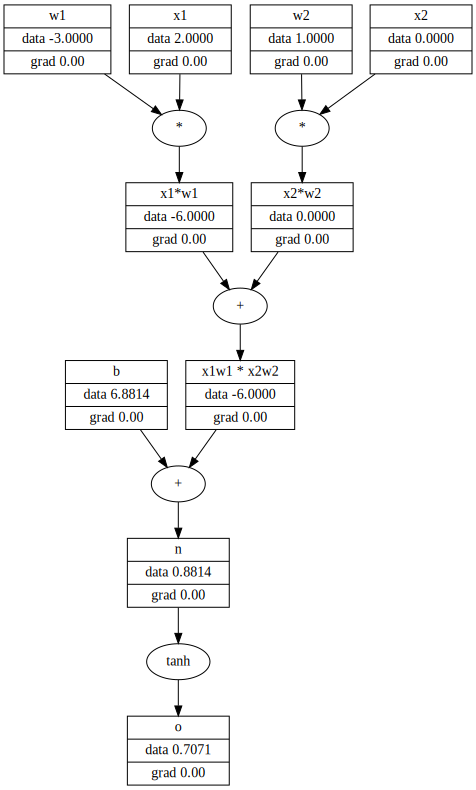

In [16]:
# inputs 
x1 = Value(data = 2.0, label = 'x1')
x2 = Value(data = 0.0, label = 'x2')

# weights
w1 = Value(data = -3.0, label = 'w1')
w2 = Value(data = 1.0, label = 'w2')

# bias of the neuron
b = Value(data = 6.8813735870195432, label = 'b')

# sum of weighted inputs
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 * x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

draw_dot(o)

In [17]:
o.grad = 1.0

In [18]:
# derivative of tanh  = 1 - tanh**2 = 1 - o**2
n.grad = 1 - o.data ** 2

In [19]:
x1w1x2w2.grad = b.grad = n.grad

In [20]:
x1w1.grad = x2w2.grad = x1w1x2w2.grad

In [21]:
w1.grad = x1.data + x1w1.grad
x1.grad = w1.data + x1w1.grad
w2.grad = x2.data + x2w2.grad
x2.grad = w2.data + x2w2.grad


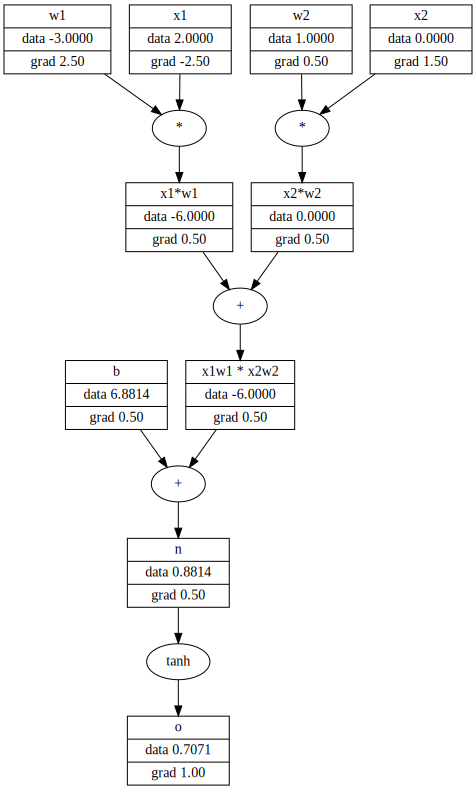

In [22]:
draw_dot(o)

In order to use the backward function, we have to keep two things in mind,
1. This must be done from the output node backwards
2. The function calculates the grad for the two Value objects which created the self object

In [23]:
o._backward()

In [24]:
n._backward()

In [25]:
b._backward()

In [26]:
x1w1x2w2._backward()

In [27]:
x1w1._backward()
x2w2._backward()

In [28]:
x1._backward()
x2._backward()
w1._backward()
w2._backward()

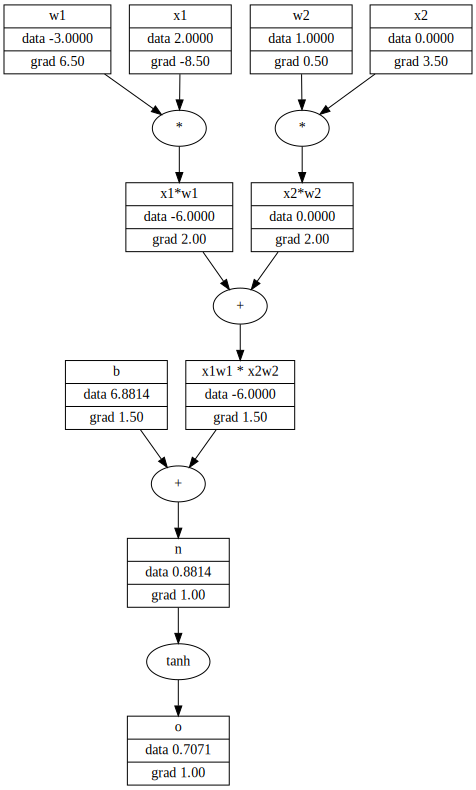

In [29]:
draw_dot(o)

In order to automatically back propogate through this graph, we can topographically sort it, i.e. each edge only going from left to right

In [30]:
topo = []
visited = set()
def build_topo(v:Value):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        # this will make sure the deepest nodes get added first
        topo.append(v)
build_topo(o)
topo


[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

Now we can call ._backward on each node in topo order  
*** This functionality has now been added in the backward() function in the Value datatype

In [31]:
o.grad = 1.0
for val in reversed(topo):
    val._backward()

### We are using an exponential format of tanh

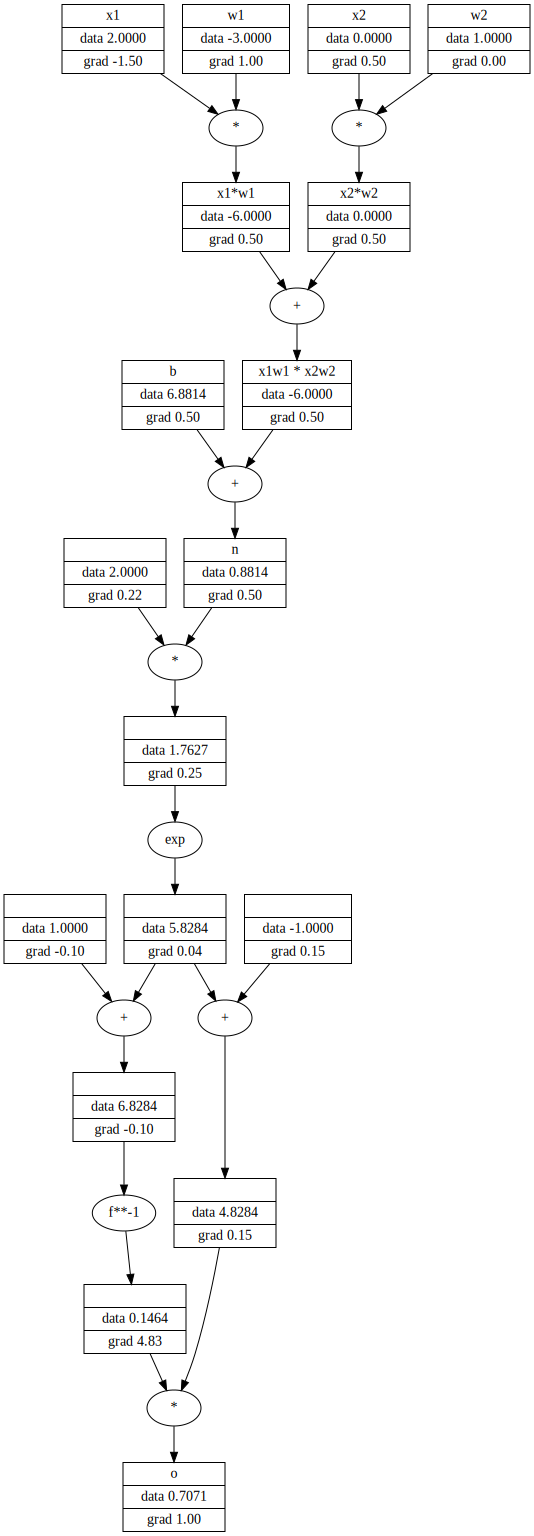

In [32]:
# inputs 
x1 = Value(data = 2.0, label = 'x1')
x2 = Value(data = 0.0, label = 'x2')

# weights
w1 = Value(data = -3.0, label = 'w1')
w2 = Value(data = 1.0, label = 'w2')

# bias of the neuron
b = Value(data = 6.8813735870195432, label = 'b')

# sum of weighted inputs
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 * x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# ----------------------------------
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'
# ----------------------------------
o.label = 'o'
o.backward()

draw_dot(o)

### Making a neuron

In [33]:
import random

In [34]:
class Neuron:
    def __init__(self,nin:int) -> None:
        '''Takes number of inputs to the neuron as input(nin) and randomizes the weights for all of them'''
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        '''This is an inbuilt function which is called when we try to call an object of this dtype as a function
            Outputs w * x + b
        '''
        # The self.b is the starting value for sum and zip puts 2 generator objects together and gets tuples
        act = sum((wi * xi for wi,xi in zip(self.w,x)),self.b)
        # weights are Value dtypes
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]        
x = [2.0,3.0]
n = Neuron(2)
n(x)


Value(data=0.509060135812563)

In [35]:
class Layer:
    # Each layer will see each neuron have the same number of inputs and outputs as mentioned when creating the object
    # nin is the number of inputs in each neuron and nout is the number of neurons in the layer
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        # NOTE: The values x are passed to each and every one of the neurons
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


In [36]:
class MLP:
    # NOTE: Here nin is the input layer dimension and so for each consecutive layer the previous nout will become the new nin so,
    # we add the nin value to the nouts values to get all the dimensions
    # Also the size of the nouts array is the number of layers

    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        # recursively get the consecutive values of x
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [70]:
# nin = 5.0
# nouts = [5,4,3]
# [nin] + nouts

x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.934296981660532)

In [38]:
# draw_dot(n(x))

### Creating a small dataset and loss function

In [63]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]

# expected outputs
ys = [1.0,-1.0,-1.0,1.0]

We will be using squared loss here

In [73]:
loss = sum((yout-ygt)**2 for yout,ygt in zip(ypred,ys))
print(loss)

Value(data=7.531306372203539)


## Training the MLP

In [45]:
# params = n.parameters()

In [64]:
learning_rate = 0.001

In [68]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for yout,ygt in zip(ypred,ys))
print(f'Iteration -1  Loss: {loss.data}')
for i in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout,ygt in zip(ypred,ys))

    # backward pass
    for param in n.parameters():
        param.grad = 0.0
    loss.backward()

    # update
    for param in n.parameters():
        param.data += -0.05 * param.grad
    
    print(f'Iteration {i}  Loss: {loss.data}')
    

Iteration -1  Loss: 7.999999958996639
Iteration 0  Loss: 7.999999958996639
Iteration 1  Loss: 7.99999999998629
Iteration 2  Loss: 7.999994407505882
Iteration 3  Loss: 7.999987631568246
Iteration 4  Loss: 7.9999999999994955
Iteration 5  Loss: 7.999999865539719
Iteration 6  Loss: 7.999999998549292
Iteration 7  Loss: 7.999999984130259
Iteration 8  Loss: 7.99999999999408
Iteration 9  Loss: 7.999999994003415
Iteration 10  Loss: 7.999999999984766
Iteration 11  Loss: 7.999999999999908
Iteration 12  Loss: 7.999999999982638
Iteration 13  Loss: 7.999999999999947
Iteration 14  Loss: 8.0
Iteration 15  Loss: 7.9999999999998685
Iteration 16  Loss: 8.0
Iteration 17  Loss: 7.999999999999762


OverflowError: math range error

In [69]:
ypred

[Value(data=-0.9999999999999701),
 Value(data=-0.9999999999999701),
 Value(data=-0.9999999999999701),
 Value(data=-0.9999999999999701)]